# Monthly Rain Reports - Version2


In [1]:
%load_ext autoreload
%autoreload 2

import logging
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from mergedownloader.inpeparser import INPE_SERVER, InpeParsers, InpeTypes
from mergedownloader.downloader import Downloader
from mergedownloader.utils import FileType
from mergedownloader.utils import GISUtil
# from rainreporter.reporter import Reporter

import rasterio as rio
import xarray as xr


## Opening Basins of INterest

In [2]:
shapes_mac = Path('/Users/cordmaur/Library/CloudStorage/OneDrive-AgênciaNacionaldeÁguas/Trabalho/SOE/COVEC/Bases/bacias de interesse SOE')
shapes_container = Path('/workspaces/reports_folder/bases/bacias_interesse')

shapes = shapes_mac if shapes_mac.exists() else shapes_container
assert shapes.exists()

In [3]:
basins = {file.stem.split('_')[-1]: file for file in shapes.iterdir() if file.suffix == '.shp'}

In [4]:
basins

{'proj': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/Bacaia_Paranaiba_diss_proj.shp'),
 'ParaibaDoSul': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_ParaibaDoSul.shp'),
 'ANA': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacias_interesse_ANA.shp'),
 'Doce': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Doce.shp'),
 'wgs84': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Doce_wgs84.shp'),
 'Itapecuru': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Itapecuru.shp'),
 'Jequitinhonha': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Jequitinhonha.shp'),
 'Madeira': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Madeira.shp'),
 'PortoVelho': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Madeira_em_PortoVelho.shp'),
 'Negro': PosixPath('/workspaces/reports_folder/bases/bacias_interesse/bacia_Negro.shp'),
 'Paraguai': 

## Create an ad-hoc report

In [5]:
from rainreporter.abstract_report import AbstractReport
from rainreporter.monthly_report import MonthlyReport
from rainreporter.utils import open_json_file
from rainreporter.mapper import Mapper

from mergedownloader.file_downloader import FileDownloader, ConnectionType, DownloadMode

In [6]:
# Create a Downloader instance
fd = FileDownloader(
    server=INPE_SERVER, 
    connection_type=ConnectionType.HTTP,
    download_mode=DownloadMode.NO_UPDATE
)
downloader = Downloader(
    file_downloader=fd,
    local_folder='/workspaces/reports_folder/downloads2',
    parsers=InpeParsers
)

Using wget through HTTP on: ftp.cptec.inpe.br


In [199]:
# Get the Shape of INterest
shp = basins['Uruguai']

In [194]:
# Create a Mapper instance
config = open_json_file('../reporter.json5')
mapper = Mapper(
    config=config['shape_style'],
    shapes=config['context_shapes']
)

../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


In [200]:
# Create the Report instance
reporter = MonthlyReport(
    downloader=downloader,
    mapper=mapper,
    shp_file=shp,
    name='Uruguai',
    month_lbk=23,
    wet_month=10,
)

In [201]:
file = Path('/workspaces/reports_folder/tmp/rcar_data.csv')
assert file.exists()


In [203]:
reporter.export_report_data('2024-06', file)

In [207]:
report = reporter.generate_report(date_str='2024-10')

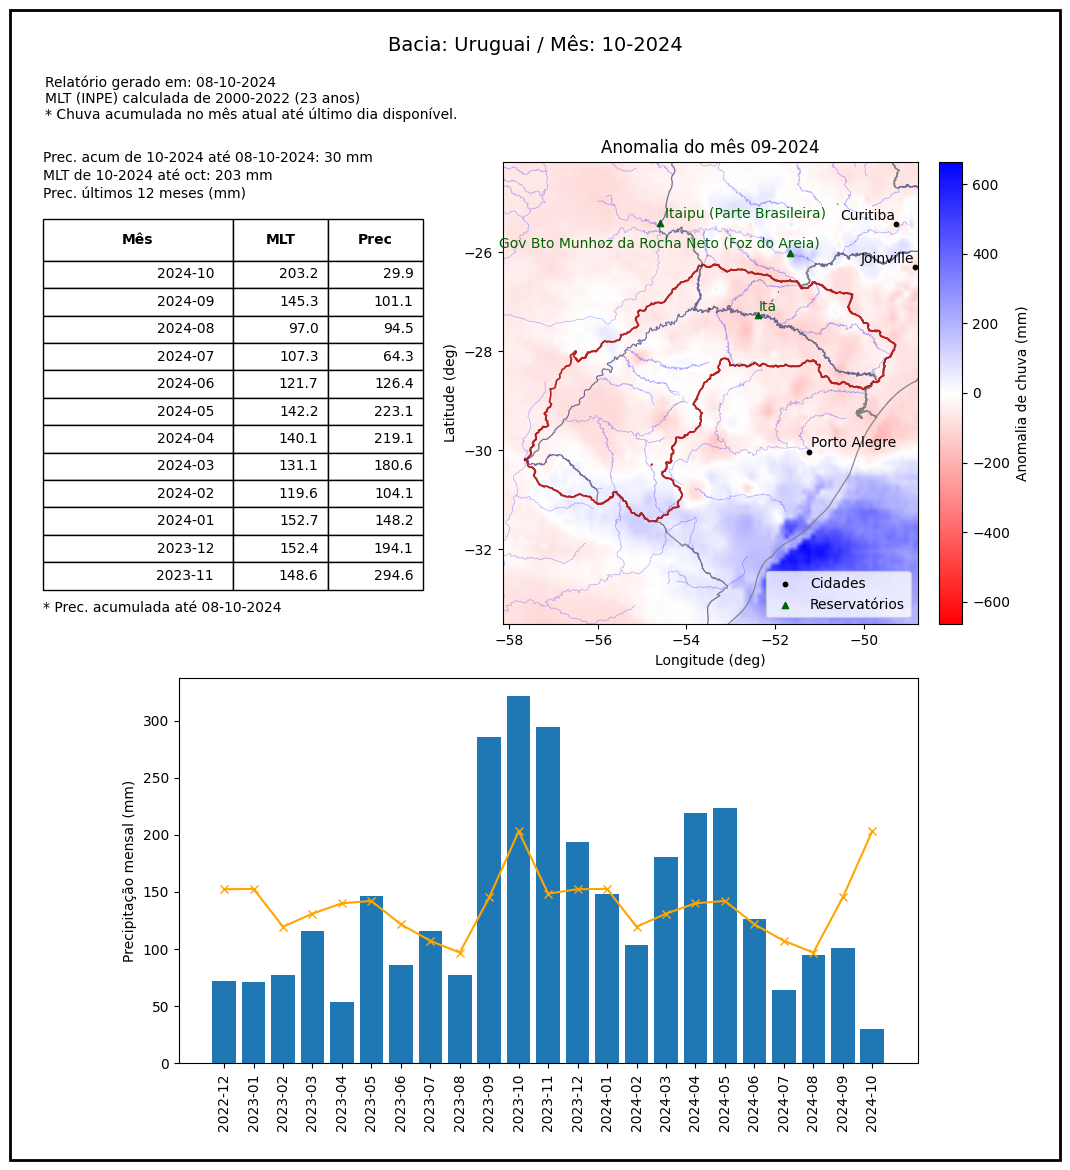

In [208]:
report[0]

In [209]:
report[2]

,time,pacum,lta,basin,last_date
month,,,,,
2022-12,2022-12-01 12:00:00,71.792572,152.435239,Uruguai,None
2023-01,2023-01-01 12:00:00,71.528534,152.726562,Uruguai,None
2023-02,2023-02-01 12:00:00,76.997223,119.607668,Uruguai,None
2023-03,2023-03-01 12:00:00,116.064720,131.081133,Uruguai,None
2023-04,2023-04-01 12:00:00,53.667637,140.137256,Uruguai,None
2023-05,2023-05-01 12:00:00,146.257217,142.184908,Uruguai,None
2023-06,2023-06-01 12:00:00,85.938828,121.714507,Uruguai,None
2023-07,2023-07-01 12:00:00,116.065811,107.299897,Uruguai,None
2023-08,2023-08-01 12:00:00,77.393471,97.003007,Uruguai,None


In [210]:
fig, ax = plt.subplots()
reporter.plot_anomaly_map(
    date='2024-09',
    shp=gdf,
    plt_ax=ax,
)

## Creating the Reporter Object

In [8]:
from rainreporter.reporter import Reporter

In [9]:
# Create a Downloader instance
fd = FileDownloader(
    server=INPE_SERVER, 
    connection_type=ConnectionType.HTTP,
    download_mode=DownloadMode.NO_UPDATE
)
downloader = Downloader(
    file_downloader=fd,
    local_folder='/workspaces/reports_folder/downloads2',
    parsers=InpeParsers
)

Using wget through HTTP on: ftp.cptec.inpe.br


In [13]:
reporter = Reporter(
    downloader=downloader, 
    log_level=logging.INFO,
    config_file='../reporter.json5'
)


../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


## Monthly Report

In [14]:
# specify report configurations
report_kwgs = {
    'shp': '/workspaces/reports_folder/bases/bacias_interesse/bacia_Doce.shp',
    'nome': "",
    'total_meses': 24,
    'inicio_periodo_chuvoso': 10,
}



In [16]:
report = reporter.generate_report(rep_type='Mensal', date_str='2024-08', **report_kwgs)

In [18]:
%matplotlib inline

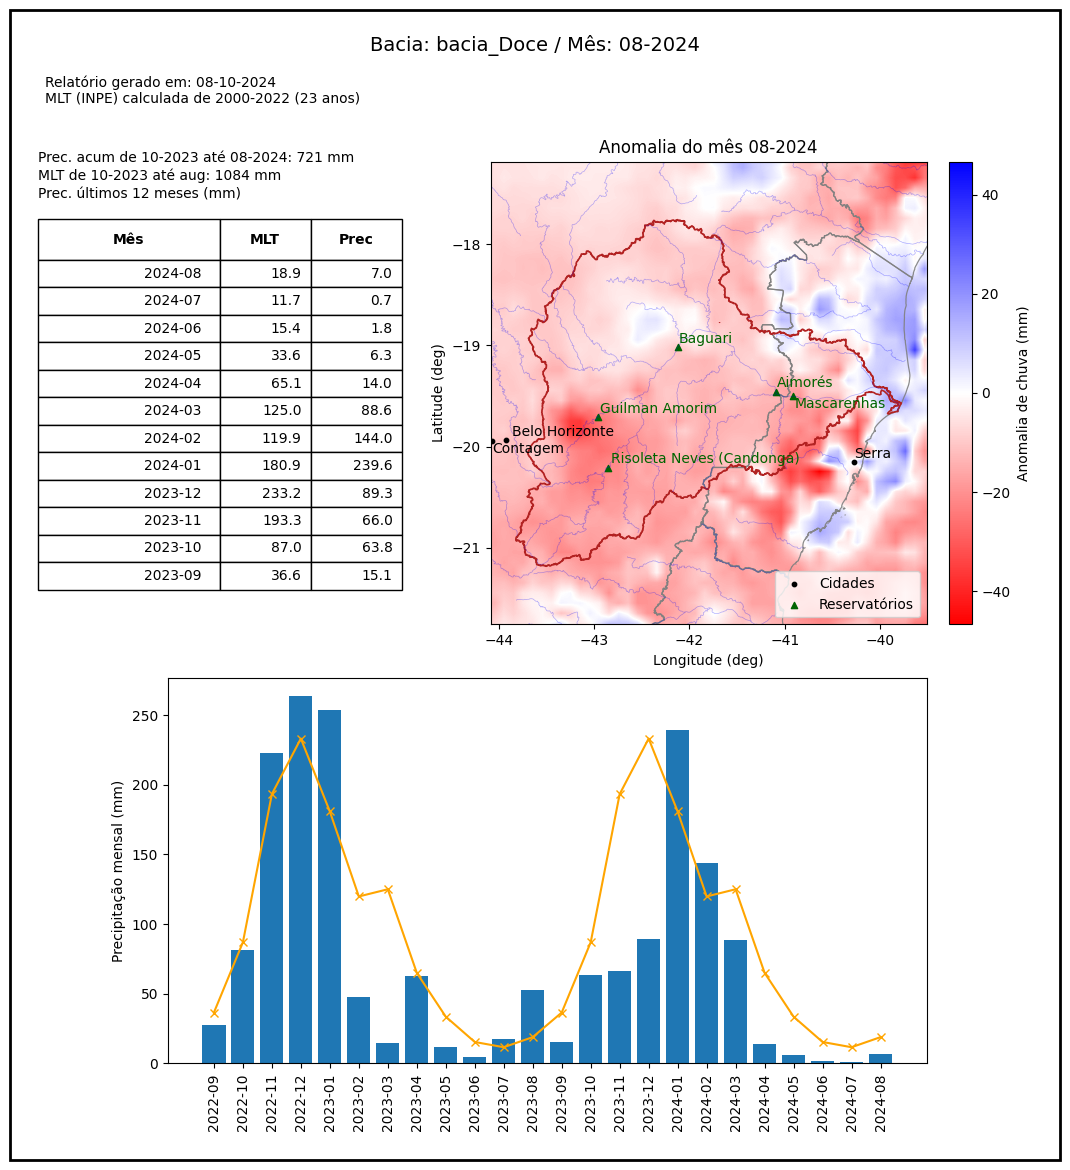

In [19]:
fig, axs, dframe, shp = report

fig

In [9]:
self = reporter
date = '2024-08'
# get the raster for the accumulated rain in the month
rain = self.downloader.create_cube(
    start_date=date, end_date=date, datatype=INPETypes.MONTHLY_ACCUM_MANUAL
).squeeze()

# get the rater for the long term average in the same month
lta = self.downloader.create_cube(
    start_date=date, end_date=date, datatype=INPETypes.MONTHLY_ACCUM
).squeeze()

In [10]:
rain.dims

('latitude', 'longitude')

In [11]:
lta.dims

('latitude', 'longitude')

In [12]:
rain2 = rain.rio.reproject_match(lta)
rain2

<xarray.DataArray 'monthacum' (y: 691, x: 551)>
array([[ 96.0625,  95.5   ,  93.3125, ...,  10.    ,  11.3125,   9.    ],
       [ 93.    ,  87.9375,  84.8125, ...,   7.25  ,   6.4375,   9.75  ],
       [ 90.5625,  89.125 ,  84.875 , ...,   8.4375,   9.875 ,   9.9375],
       ...,
       [247.375 , 268.125 , 254.125 , ...,  91.9375,  97.1875,  76.9375],
       [239.1875, 234.125 , 229.6875, ..., 106.875 , 109.1875,  98.    ],
       [225.1875, 241.0625, 232.0625, ..., 102.5   , 107.3125,  94.8125]],
      dtype=float32)
Coordinates:
  * x            (x) float64 -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * y            (y) float64 -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
    surface      float64 2.55e+03
    step         timedelta64[ns] 00:00:00
    time         datetime64[ns] 2024-08-01T12:00:00
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

In [13]:
lta2 = lta.rio.reproject_match(rain)

In [14]:
lta2

<xarray.DataArray 'precacum' (y: 924, x: 1001)>
array([[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       ...,
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38]], dtype=float32)
Coordinates:
  * x            (x) float64 -120.1 -120.0 -119.9 ... -20.25 -20.15 -20.05
  * y            (y) float64 -60.05 -59.95 -59.85 -59.75 ... 32.05 32.15 32.25
    time         datetime64[ns] 2023-08-01T12:00:00
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

In [17]:
anomaly = lta.copy()
anomaly.data = rain2.data - lta.data

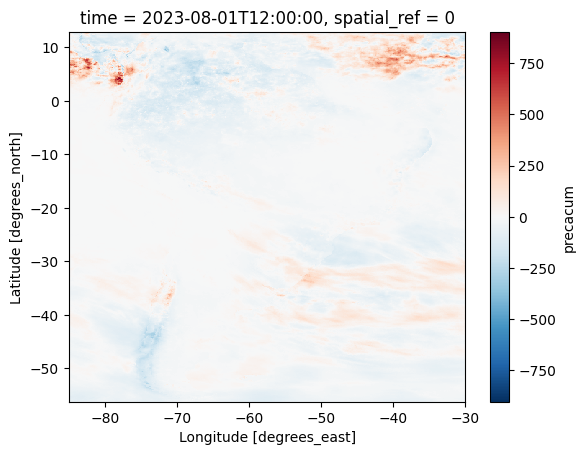

In [18]:
anomaly.plot()

In [60]:
rain.rio.bounds() == rain.rio.bounds()

True

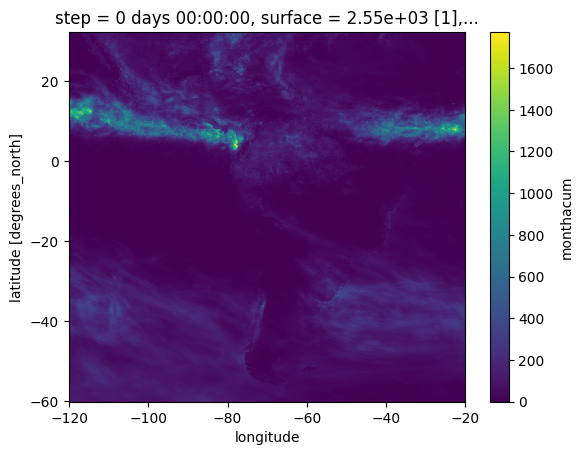

In [55]:
rain.plot()

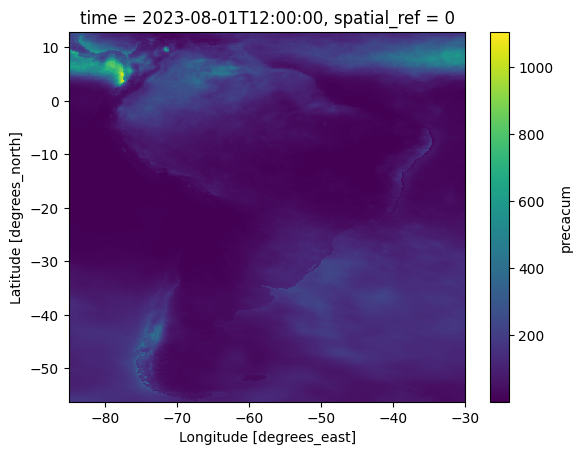

In [56]:
lta.plot()

In [50]:
rain

Signature: rain.__sub__(other)
Docstring: Same as a - b.
File:      /usr/local/lib/python3.10/dist-packages/xarray/core/_typed_ops.py
Type:      method

In [40]:
rain.shape

(924, 1001)

In [41]:
lta.shape

(691, 551)

In [42]:
rain.rio.reproject(dst_crs=lta.rio.crs, shape=lta.shape).shape

(691, 551)

In [26]:
rain

<xarray.DataArray 'monthacum' (y: 691, x: 551)>
array([[  0.    ,   0.    ,   0.    , ...,   0.    ,   0.625 ,   0.125 ],
       [  0.    ,   0.    ,   0.    , ...,   0.125 ,   0.    ,   0.25  ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       ...,
       [109.5   , 107.125 , 105.9375, ...,   6.875 ,   7.4375,   7.375 ],
       [109.5   , 106.5   , 105.1875, ...,   6.375 ,   4.75  ,   5.6875],
       [ 37.75  , 108.125 , 103.1875, ...,   6.1875,   6.625 ,   6.5   ]],
      dtype=float32)
Coordinates:
  * x            (x) float64 -120.0 -119.8 -119.6 ... -20.45 -20.27 -20.09
  * y            (y) float64 32.23 32.1 31.97 31.83 ... -59.77 -59.9 -60.03
    surface      float64 2.55e+03
    time         datetime64[ns] 2024-08-01T12:00:00
    step         timedelta64[ns] 00:00:00
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

In [34]:
lta.dims

('latitude', 'longitude')

In [33]:
anomaly.dims

('y', 'x')

# Process Hot Folder

In [3]:
reporter = Reporter(
    server=INPEParsers.FTPurl, 
    download_folder='/workspaces/reports_folder/downloads', 
    log_level=logging.DEBUG,
    bases_folder='/workspaces/reports_folder/bases/',
    config_file='../reporter.json5'

    # parsers=INPEParsers.parsers,
    # post_processors=INPEParsers.post_processors
)


../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


In [ ]:

reporter.process_folder(
    input_folder='/workspaces/reports_folder/hot_folder/',
    output_folder='/workspaces/reports_folder/output/',
    hot=False
)

# Process Entire Folder

In [35]:
reporter = Reporter(
    server=INPEParsers.FTPurl, 
    download_folder='/workspaces/reports_folder/downloads', 
    log_level=logging.INFO,
    bases_folder='/workspaces/reports_folder/bases/',
    config_file='../reporter.json5'
    # parsers=INPEParsers.parsers,
    # post_processors=INPEParsers.post_processors
)

../data/cities/cidades.shp
../data/states/BR_UF_2022.shp
../data/rivers/main_rivers.shp
../data/dams


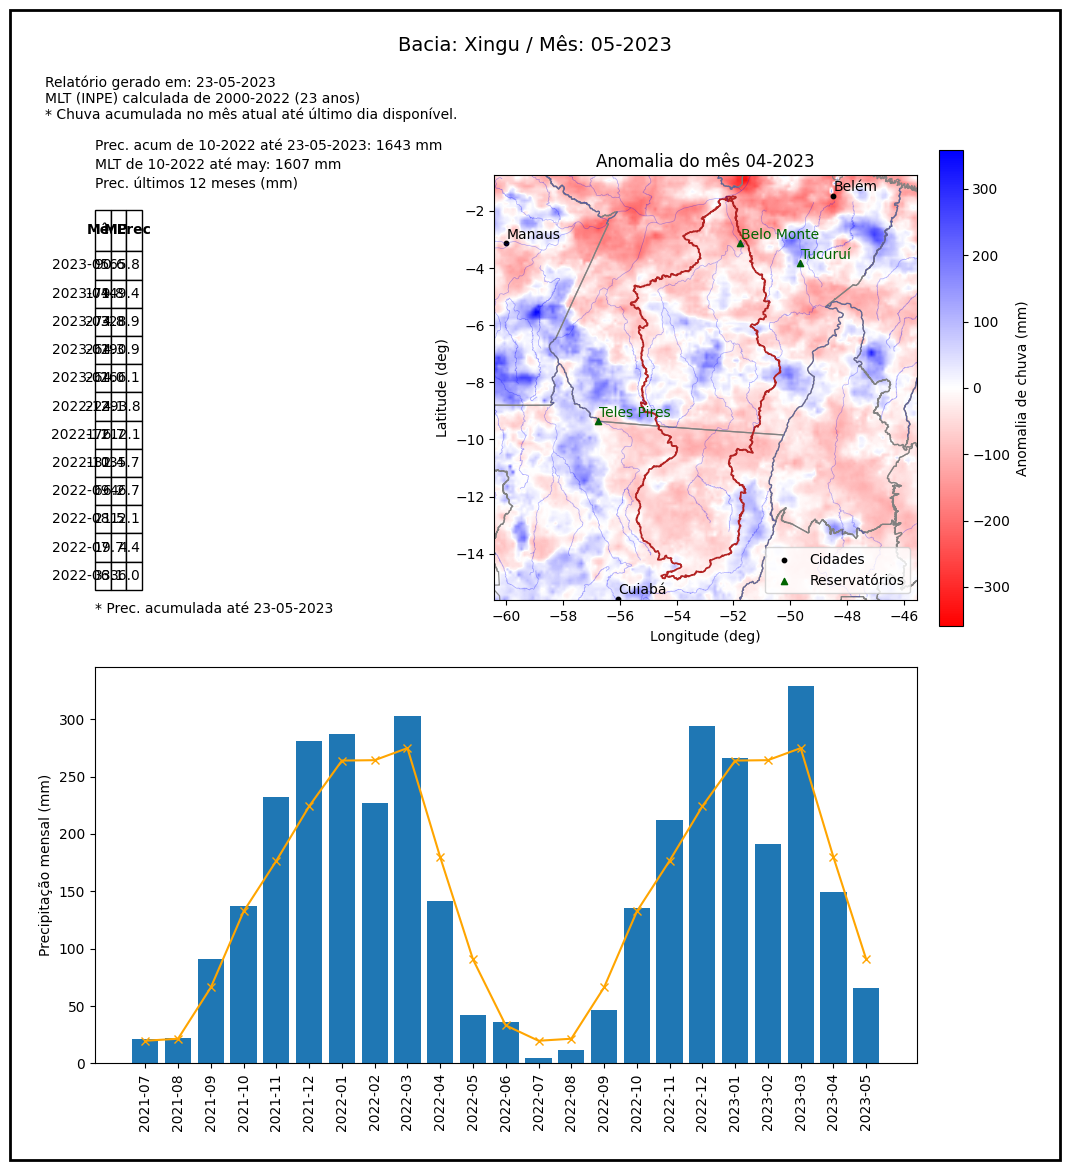

In [36]:
reporter.process_folder(
    input_folder='/workspaces/reports_folder/configs/',
    output_folder='/workspaces/reports_folder/output/'
)

In [3]:
shapes_container = Path('/workspaces/reports_folder/bases/BaciasIncrementais')
shapes_container.exists()


True

In [4]:
sf = shapes_container/'SaoFrancisco'

In [7]:
tres_marias = gpd.read_file(sf/'Incre_3_Marias_diss_proj.shp')

In [13]:
tres_marias

,Id,Nome,Area_km²,geometry
0,0,UHE Três Marias,57545.578138,"POLYGON ((-5052729.760 -2054701.559, -5052723...."


<Axes: >

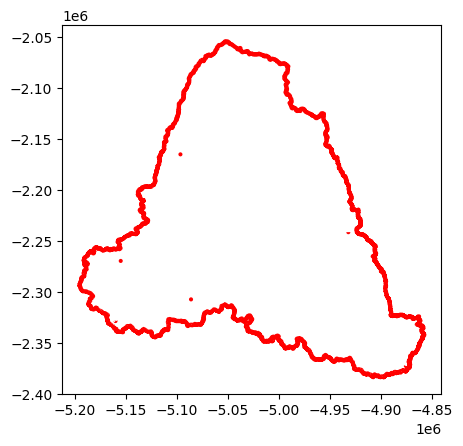

In [10]:
tres_marias.plot(facecolor='none', edgecolor= 'red', linewidth=3)

<Axes: >

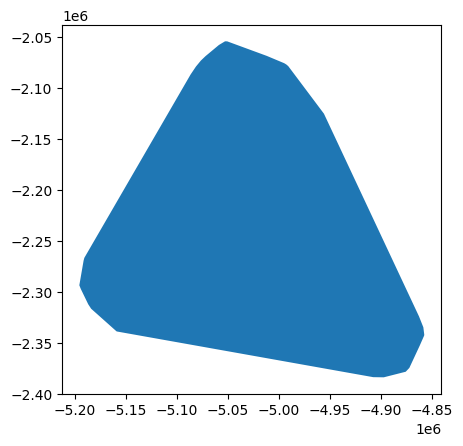

In [14]:
tres_marias.convex_hull.plot()

<Axes: >

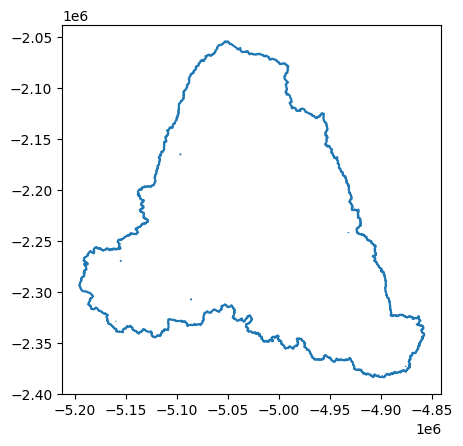

In [12]:
tres_marias.boundary.plot()